In [44]:
from pathlib import Path
import packaging
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Fetching Data

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
print(type(mnist))
print(type(mnist.data))
print(type(mnist.target))

<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
X, y = mnist.data, mnist.target
print("X info:")
print(X.shape)
print(type(X))
print(X)
print("----------------")
print("y info:")
print(y.shape)
print(type(y))
print(y)

X info:
(70000, 784)
<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
----------------
y info:
(70000,)
<class 'numpy.ndarray'>
['5' '0' '4' ... '4' '5' '6']


Display one of the image to get better intuition about data.

y label = 5


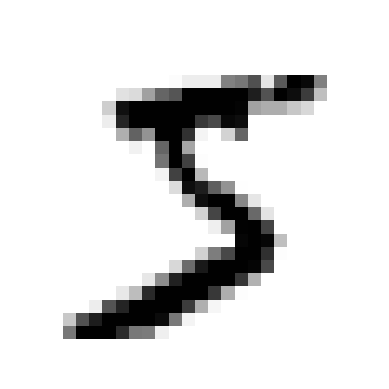

In [5]:
def plot_digit(image_data):
    image =image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

digit = X[0]
print(f"y label = {y[0]}" )

plot_digit(digit)
plt.show()

Display first 100 digits from the dataset:

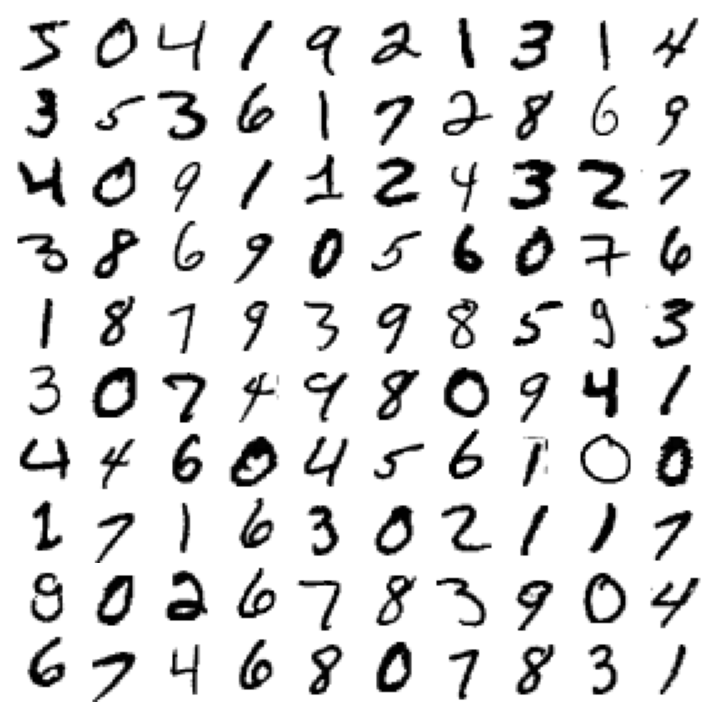

In [6]:
plt.figure(figsize=(9,9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx+1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [8]:
y_train_5 = (y_train == '5') # true for all 3s, false for all othe digits
y_test_5 = (y_test == '5')

In [9]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([digit])

array([ True])

# Performance Measures

## Measuring accuracy using cross-validation

In [11]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

<b>Custom cross_validation function:</b>


In [12]:
skfolds = StratifiedKFold(n_splits=3, shuffle=False)

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    print(f"Train idx:{train_idx}")
    print(f"Test idx:{test_idx}")
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    print(X_train_folds.shape)
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_train[test_idx]
    print(X_test_fold.shape)
    y_test_fold = y_train_5[test_idx]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_prediction = clone_clf.predict(X_test_fold)
    n_correct = sum(y_prediction == y_test_fold)
    print(f"Accuracy = {n_correct / len(y_prediction)}")

Train idx:[19964 19965 19966 ... 59997 59998 59999]
Test idx:[    0     1     2 ... 20331 20342 20359]
(40000, 784)
(20000, 784)
Accuracy = 0.95035
Train idx:[    0     1     2 ... 59997 59998 59999]
Test idx:[19964 19965 19966 ... 40088 40125 40127]
(40000, 784)
(20000, 784)
Accuracy = 0.96035
Train idx:[    0     1     2 ... 40088 40125 40127]
Test idx:[39988 39989 39990 ... 59997 59998 59999]
(40000, 784)
(20000, 784)
Accuracy = 0.9604


<b>Let’s look at a dummy classifier that just classifies every single
image in the most frequent class, which in this case is the negative class:</b>

In [13]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [14]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

So, as we see, accuracy is generally not the best performance
measure for classifiers, especially when we are dealing with skewed
datasets.

## Confusion Matrix

The general idea of a confusion matrix is to count the number of times
instances of class A are classified as class B, for all A/B pairs.

Confusion matrix (*from Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd ed. book written by Aurélien Géron*):
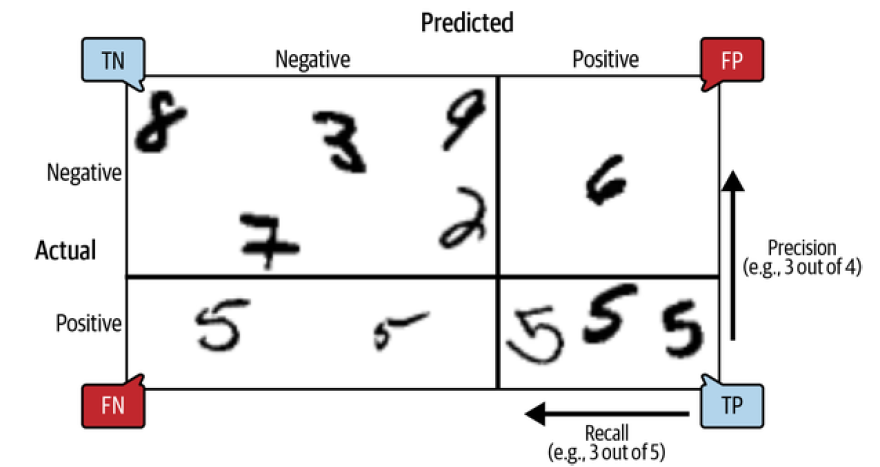

In [15]:
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
print(y_train_predict.shape)
print(y_train_predict)

(60000,)
[ True False False ...  True False False]


In [17]:
cm = confusion_matrix(y_train_5, y_train_predict)

In [18]:
print(cm)

[[53892   687]
 [ 1891  3530]]


## Precision and Recall

In [19]:
precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

In [21]:
f1_score(y_train_5, y_train_predict)

0.7325171197343846

In [22]:
y_scores = sgd_clf.decision_function([digit])
y_scores

array([2164.22030239])

Threshold - is a score for making decision in SGDClassifier.

If score < threshold - negative class, if score > threshold - positive.

In [23]:
threshold = 0
y_digit_pred = y_scores > threshold
y_digit_pred

array([ True])

In [24]:
threshold = 3000
y_digit_pred = y_scores > threshold
y_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

#### Precision-recall curve

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions)


[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]


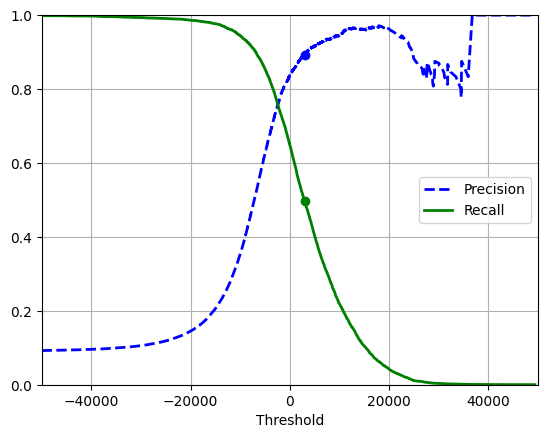

In [28]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

# make more beautiful visualisation
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
#

plt.show()

#### Precision/Recall curve

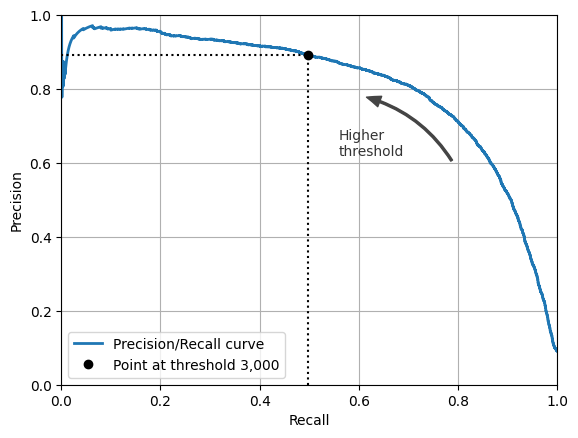

In [29]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
#

plt.show()

Let's find index of threshold by precision value:

In [30]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [31]:
y_train_pred_90 = y_scores >= threshold_for_90_precision

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC Curve

The ROC curve plots the **true positive rate** (another name for recall) against the **false positive rate (FPR)**.

The FPR (also called the fall-out) is the ratio of negative instances that are
incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified
as negative. The TNR is also called specificity. Hence, the ROC curve plots
sensitivity (recall) versus 1 – specificity.

In [37]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

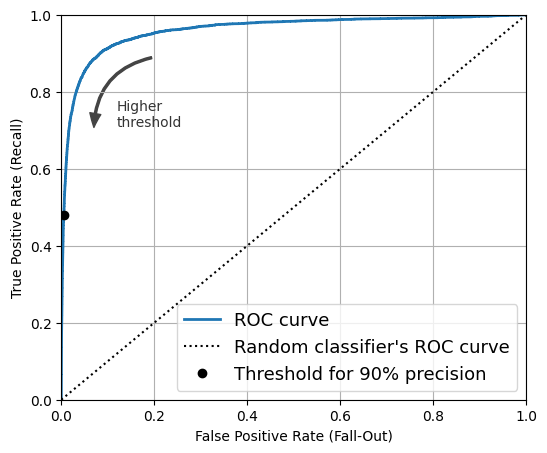

In [40]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
#

plt.show()

In [43]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [47]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [50]:
y_probas_forest[:3]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04]])

In [53]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

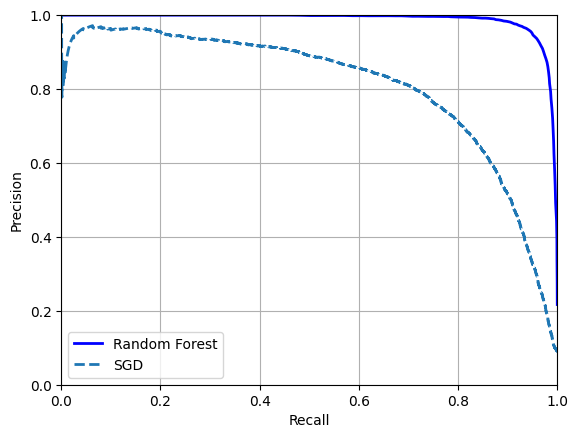

In [54]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
#

plt.show()